# This Notebook contains the initial brainstorming of Preprocessing pipeline for the Age invariant Face matching system , which i tried it only on one single image

# Packages Installation

In [1]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
pip uninstall pillow -y


Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0


In [ ]:
pip install pillow==9.5.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-9.5.0-cp312-cp312-linux_x86_64.whl size=1210285 sha256=2408a1608e13aa89ee6c299fc47df0a28f66b19e0fb3f5a01739b09deb270ef9
  Stored in directory: /root/.cache/pip/wheels/ea/de/2e/75a6399e5d8cd3a55c13c8f0658d996d4ce4cff37389de044c
Successfully built pillow
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


# Pre-processing Steps

# 1- MTCNN (For face detection & Facial Landmarks detection)

(640, 640)


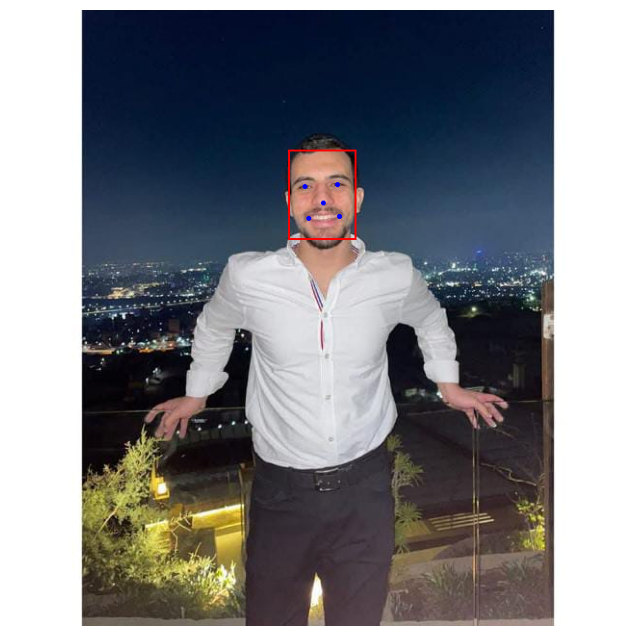

In [10]:
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw
import numpy as np
import cv2
from matplotlib import pyplot as plt

# --------------------------
# 1. Load MTCNN
# --------------------------
mtcnn = MTCNN()

# --------------------------
# 2. Load image
# --------------------------
img_path = '/content/ahmed.jpeg'

img = Image.open(img_path)
print(img.size)
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

# --------------------------
# 3. Detect faces and landmarks
# --------------------------
boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)

# --------------------------
# 4. Draw detection results
# --------------------------
draw = ImageDraw.Draw(img)
if boxes is not None:
    for box in boxes:
        draw.rectangle(box.tolist(), outline='red', width=2)

if landmarks is not None:
    for landmark in landmarks:
        for point in landmark:
            x, y = point
            draw.ellipse((x-2, y-2, x+2, y+2), fill='blue')

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()





# 2- Allignment for facial Landmarks & Cropping and resizing for Model input size

In [11]:
# --------------------------
# 5. Function for face alignment
# --------------------------
def align_face(img_cv, landmark, output_size=(160,160)):
    """
    Align face based on eyes and nose landmarks.

    Args:
        img_cv: OpenCV image
        landmark: [left_eye, right_eye, nose, left_mouth, right_mouth]
        output_size: tuple of (width, height)
    Returns:
        aligned_face: aligned face image (OpenCV)
    """
    left_eye = landmark[0]
    right_eye = landmark[1]
    nose = landmark[2]

    # Compute center between eyes
    eyes_center = ((left_eye[0]+right_eye[0])/2, (left_eye[1]+right_eye[1])/2)

    # Compute angle between eyes
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Compute scale
    desired_eye_distance = output_size[0] * 0.35
    dist = np.sqrt(dx**2 + dy**2)
    scale = desired_eye_distance / dist

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Translate to center
    tX = output_size[0] * 0.5
    tY = output_size[1] * 0.4
    M[0,2] += (tX - eyes_center[0])
    M[1,2] += (tY - eyes_center[1])

    # Apply affine transformation
    aligned_face = cv2.warpAffine(img_cv, M, output_size, flags=cv2.INTER_CUBIC)

    return aligned_face


# Show alligned  results

(160, 160, 3)


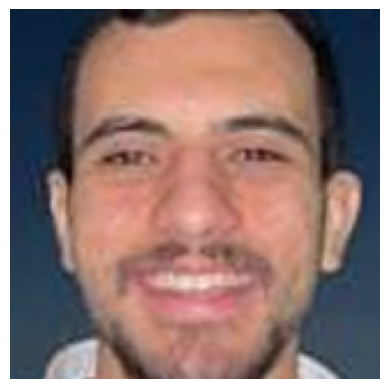

In [12]:
# --------------------------
# 6. Align all detected faces
# --------------------------
aligned_faces = []
if landmarks is not None:
    for landmark in landmarks:
        aligned = align_face(img_cv, landmark)
        print(aligned.shape)
        aligned_faces.append(aligned)
        # Display each aligned face
        plt.figure()
        plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()